# Load data

"spider\train_spider.json"

In [7]:
import data
import tensorflow as tf

In [2]:
handlr = data.Train_Data('D:/DS/Learnin/Essex MS/CE888/git/CE888/assignment2/seq2seq/spider/',['train_spider.json','train_others.json'])
input_text_processor = data.Features().vectorizor(handlr.questions , data.Max_Vocab_Size)
output_text_processor = data.Features().vectorizor(handlr.sql , data.Max_Vocab_Size)

Reading file at path D:/DS/Learnin/Essex MS/CE888/git/CE888/assignment2/seq2seq/spider/train_spider.json
7000 Rows in Total
Reading file at path D:/DS/Learnin/Essex MS/CE888/git/CE888/assignment2/seq2seq/spider/train_others.json
8659 Rows in Total
Filter Easy Queries
Splittin the Train and Test data
(727, 7)
Data for Training (2908, 7)
Data for Testing (727, 7)
Sample Vocabulary ['', '[UNK]', 'the', '[start]', '[end]', 'of', '?', '.', 'what', 'are']
Sample Vocabulary ['', '[UNK]', 'select', 'from', '[start]', '[end]', 'where', ')', '(', '=']


In [3]:
input_text_processor.vocabulary_size()

2253

In [5]:
inp = handlr.questions
targ = handlr.sql

In [6]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = data.BATCH_SIZE

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [9]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

tf.Tensor(
[b'Show the names of members whose country is "United States" or "Canada".'
 b'What are the dates of the assessment notes?'
 b'What is the average time span of contact channels in the database?'
 b'What is the average number of bank customers?'
 b'What campuses are located in Los Angeles county and opened after 1950?'], shape=(5,), dtype=string)

tf.Tensor(
[b'SELECT Name FROM member WHERE Country  =  "United States" OR Country  =  "Canada"'
 b'SELECT date_of_notes FROM Assessment_Notes'
 b'SELECT avg(active_to_date - active_from_date) FROM customer_contact_channels'
 b'SELECT avg(no_of_customers) FROM bank'
 b'SELECT campus FROM campuses WHERE county  =  "Los Angeles" AND YEAR  >  1950'], shape=(5,), dtype=string)


In [10]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :]

<tf.Tensor: shape=(3, 26), dtype=int64, numpy=
array([[   3,   27,    2,   14,    5,  120,   35,  147,   13, 1480, 1076,
          38, 1024,    7,    4,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   3,    8,    9,    2,   96,    5,    2,  990, 1162,    6,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   3,    8,   13,    2,   32,  232, 1082,    5,  593,  520,   11,
           2,  298,    6,    4,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int64)>

In [11]:
import numpy as np
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[start] show the names of members whose country is "united states" or "canada" . [end]           '

Text(0.5, 1.0, 'Mask')

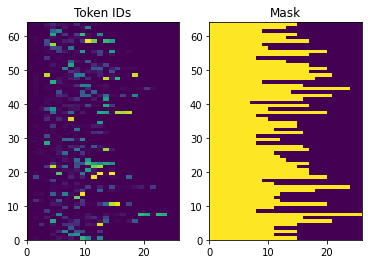

In [12]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [14]:
embedding_dim = data.embedding_dim
units = data.units

In [15]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                                embedding_dim)

        # The GRU RNN layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                    # Return the sequence and state
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')

    def call(self, tokens, state=None):
        


        # 2. The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)


        # 3. The GRU processes the embedding sequence.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)


        # 4. Returns the new sequence and its state.
        return output, state

In [16]:
input_text_processor.vocabulary_size()

2253

In [17]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 26)
Encoder output, shape (batch, s, units): (64, 26, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # For Eqn. (4), the  Bahdanau attention
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
       
        # From Eqn. (4), `W1@ht`.
        w1_query = self.W1(query)
       
        # From Eqn. (4), `W2@hs`.
        w2_key = self.W2(value)

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores = True,
        )

        return context_vector, attention_weights

In [19]:
attention_layer = BahdanauAttention(units)

In [20]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 26)


Text(0.5, 1.0, 'Mask')

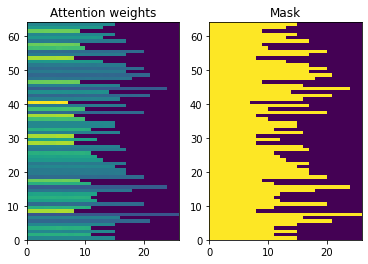

In [21]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [22]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

In [23]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [24]:
import typing
from typing import Any, Tuple

class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [25]:
def call(self, inputs: DecoderInput, state=None) -> Tuple[DecoderOutput, tf.Tensor]:

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
 

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)

  return DecoderOutput(logits, attention_weights), state

In [26]:
Decoder.call = call

In [27]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [29]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[start]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [30]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 2099)
state shape: (batch_size, dec_units) (64, 1024)


In [31]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [32]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['pilot'],
       ['club"'],
       ['"cleavant'],
       ["'full'"],
       ['city_name']], dtype='<U37')

In [33]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [34]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['launch_year'],
       ['genres;'],
       ['card_number'],
       ['dateundergoes'],
       ['636']], dtype='<U37')

In [35]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):
        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)

In [36]:
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(input_text_processor.vocabulary_size(),
                        embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),
                        embedding_dim, units)

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function

    def train_step(self, inputs):
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
         return self._train_step(inputs)

In [37]:
def _preprocess(self, input_text, target_text):
  

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  

  # Convert IDs to masks.
  input_mask = input_tokens != 0
 

  target_mask = target_tokens != 0
  

  return input_tokens, input_mask, target_tokens, target_mask

In [38]:
TrainTranslator._preprocess = _preprocess

In [39]:
def _train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask,target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]

    with tf.GradientTape() as tape:
        # Encode the input
        enc_output, enc_state = self.encoder(input_tokens)
        

        # Initialize the decoder's state to the encoder's final state.
        # This only works if the encoder and decoder have the same number of
        # units.
        dec_state = enc_state
        loss = tf.constant(0.0)

        for t in tf.range(max_target_length-1):
            # Pass in two tokens from the target sequence:
            # 1. The current input to the decoder.
            # 2. The target for the decoder's next prediction.
            new_tokens = target_tokens[:, t:t+2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                    enc_output, dec_state)
            loss = loss + step_loss

    # Average the loss over all non padding tokens.
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

In [40]:
TrainTranslator._train_step = _train_step

In [41]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                                enc_output=enc_output,
                                mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)


    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state

In [42]:
TrainTranslator._loop_step = _loop_step

In [43]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [44]:
np.log(output_text_processor.vocabulary_size())

7.649216319820633

In [45]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.0313325>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.9751773>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.855935>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.4688644>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.1975126>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.910534>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3237343>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3402195>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.259539>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0715237>}

Wall time: 33.9 s


In [46]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [47]:
TrainTranslator._tf_train_step = _tf_train_step


In [48]:
translator.use_tf_function = True


In [49]:
translator.train_step([example_input_batch, example_target_batch])


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.91424>}

In [50]:
%%time
for n in range(3):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9558828>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8005328>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7824287>}

Wall time: 6.5 s


In [110]:
# losses = []
# for n in range(100):
#   print('.', end='')
#   logs = translator.train_step([example_input_batch, example_target_batch])
#   losses.append(logs['batch_loss'].numpy())

# print()
# plt.plot(losses)

In [93]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

# loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
# train_translator = TrainTranslator(
#     embedding_dim, units,
#     input_text_processor=input_text_processor,
#     output_text_processor=output_text_processor)

# # Configure the loss and optimizer
# train_translator.compile(
#     optimizer=tf.optimizers.Adam(),
#     loss=loss,
#     metrics=['accuracy'],
# )

In [94]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [95]:
train_translator.fit(dataset, epochs=50)

Epoch 1/50
46/46 [==============================] - 140s 3s/step - batch_loss: 4.5901
Epoch 2/50
46/46 [==============================] - 152s 3s/step - batch_loss: 2.8263
Epoch 3/50
46/46 [==============================] - 152s 3s/step - batch_loss: 2.1858
Epoch 4/50
46/46 [==============================] - 155s 3s/step - batch_loss: 1.8859
Epoch 5/50
46/46 [==============================] - 156s 3s/step - batch_loss: 1.6298
Epoch 6/50
46/46 [==============================] - 156s 3s/step - batch_loss: 1.4095
Epoch 7/50
46/46 [==============================] - 160s 3s/step - batch_loss: 1.1777
Epoch 8/50
46/46 [==============================] - 163s 4s/step - batch_loss: 0.9738
Epoch 9/50
46/46 [==============================] - 183s 4s/step - batch_loss: 0.7967
Epoch 10/50
46/46 [==============================] - 434s 9s/step - batch_loss: 0.6378
Epoch 11/50
46/46 [==============================] - 469s 10s/step - batch_loss: 0.5073
Epoch 12/50
46/46 [==============================] 

Text(0, 0.5, 'CE/token')

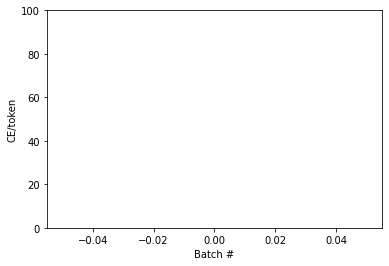

In [98]:
plt.plot(batch_loss.logs)
plt.ylim([0, 100])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [99]:
batch_loss.logs

[]

In [100]:
class Translator(tf.Module):
    
  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[unk]', '[start]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[start]'))
    self.end_token = index_from_string(tf.constant('[end]'))

In [101]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [102]:
def tokens_to_text(self, result_tokens):
    
    result_text_tokens = self.output_token_string_from_index(result_tokens)
   

    result_text = tf.strings.reduce_join(result_text_tokens,
                                        axis=1, separator=' ')
    

    result_text = tf.strings.strip(result_text)
    
    return result_text

In [103]:
Translator.tokens_to_text = tokens_to_text

In [104]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'2007 pets_allowed_yn', b'technician_id stuid',
       b'keyword; "edmonton"', b'ycard job', b'2003 "howard"'],
      dtype=object)

In [105]:
def sample(self, logits, temperature):

    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]

    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)

    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else: 
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits/temperature,
                                            num_samples=1)

    return new_tokens

Translator.sample = sample


In [106]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 468],
       [1165],
       [2046],
       [1803],
       [1674]], dtype=int64)>

In [107]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [108]:
Translator.translate = translate_unrolled

In [109]:
%%time
input_text = tf.constant([
    'How many singers do we have?', # "It's really cold here."
    'What is the total number of singers?', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

select count ( * ) from wrestler
select sum ( gamesplayed ) from sportsinfo

Wall time: 192 ms
